In [1]:
%load_ext rpy2.ipython
%load_ext autotime
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import sys
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation
from pprint import pprint

R[write to console]: Installing package into ‘/home/stephan/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



Reinstalling childesr version 0.2.1


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/childesr_0.2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 22865 bytes (22 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso

time: 10.4 s (started: 2022-06-15 06:55:53 -07:00)


In [2]:
%%R
# load R dependencies
library('plyr')
library('tidyr')
library('plotROC')
library('pROC')
library('lme4')

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




time: 1.6 s (started: 2022-06-15 06:56:03 -07:00)


In [3]:
sys.path.append('../../')
from src.utils import sample_models_across_time, load_models, hyperparameter_utils, configuration, paths
config = configuration.Config()

time: 202 ms (started: 2022-06-15 06:56:05 -07:00)


In [4]:
%%R
filter_model_subset = function(this_df, model_names_list){
    #return(this_df[this_df$model %in% model_names_list])
    return(subset(this_df, this_df$model %in% model_names_list))
}

sem <- function(x) sd(x)/sqrt(length(x))

time: 8.06 ms (started: 2022-06-15 06:56:05 -07:00)


# Load Scores and move to R

In [5]:
import imp
imp.reload(sample_models_across_time)
imp.reload(load_models)
imp.reload(hyperparameter_utils)
imp.reload(paths)
config = configuration.Config()

time: 6.33 ms (started: 2022-06-15 06:56:05 -07:00)


In [6]:
levdist_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('levdist'))
# Remove 0.5 and 4.0 because they are sparse.
levdist_scores_across_time = levdist_scores_across_time[~levdist_scores_across_time.age.isin({0.5, 4.0})]
levdist_scores_across_time['likelihood_type'] = 'Levenshtein Distance'

Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxBERT_Providence_all_0/levdist_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxBERT_Providence_all_20/levdist_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxBERT_Providence_all_0/levdist_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxBERT_Providence_all_20/levdist_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Age_young_with_tagsxBERT_Providence_all_0/levdist_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/exper

In [7]:
np.unique(levdist_scores_across_time.model)

array(['eval_Providence-Age_old_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_BERT_Providence_all_0',
       'eval_Providence_all_no_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_data_unigram_Providence_all_0',
       'eval_Providence_all_with_tags_BERT_Providence_all_0',
       'eval_Providence_all_with_tags_BERT_Providence_all_20',
       'eval_Switchboard_all_no_tags_BERT_Providence_all_0',
       'eval_Switchboard_all_no_tags_BERT_Providence_all_20',
       'eval_adult-written_all_

time: 660 ms (started: 2022-06-15 06:56:09 -07:00)


In [8]:
wfst_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('wfst'))
# Remove 0.5 and 4.0 because they are sparse.
wfst_scores_across_time = wfst_scores_across_time[~wfst_scores_across_time.age.isin({0.5, 4.0})]
wfst_scores_across_time['likelihood_type'] = 'WFST'

Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxBERT_Providence_all_0/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_with_tagsxBERT_Providence_all_20/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxBERT_Providence_all_0/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence_all_no_tagsxBERT_Providence_all_20/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Age_young_with_tagsxBERT_Providence_all_0/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_sca

In [9]:
np.unique(wfst_scores_across_time.model)

array(['eval_Providence-Age_old_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_old_with_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_no_tags_BERT_Providence_all_20',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_0',
       'eval_Providence-Age_young_with_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_BERT_Providence_all_0',
       'eval_Providence_all_no_tags_BERT_Providence_all_20',
       'eval_Providence_all_no_tags_data_unigram_Providence_all_0',
       'eval_Providence_all_with_tags_BERT_Providence_all_0',
       'eval_Providence_all_with_tags_BERT_Providence_all_20',
       'eval_Switchboard_all_no_tags_BERT_Providence_all_0',
       'eval_Switchboard_all_no_tags_BERT_Providence_all_20',
       'eval_adult-written_all_

time: 476 ms (started: 2022-06-15 06:56:13 -07:00)


In [10]:
scores_across_time = pd.concat([levdist_scores_across_time, wfst_scores_across_time])

time: 2.17 s (started: 2022-06-15 06:56:14 -07:00)


In [11]:
# this takes forever -- moving things into R is expensive
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_probability','posterior_entropy','prior_probability','prior_entropy',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance','likelihood_type','prior_rank','posterior_rank']]
%R -i scores_across_time_short 

time: 2min 11s (started: 2022-06-15 06:56:16 -07:00)


In [12]:
%%R
levels(factor(scores_across_time_short$model))

 [1] "eval_adult-written_all_no_tags_BERT_Providence_all_0"          
 [2] "eval_adult-written_all_no_tags_BERT_Providence_all_20"         
 [3] "eval_no-split_no-dataset_no_tags_flat_unigram_Providence_all_0"
 [4] "eval_Providence_all_no_tags_BERT_Providence_all_0"             
 [5] "eval_Providence_all_no_tags_BERT_Providence_all_20"            
 [6] "eval_Providence_all_no_tags_data_unigram_Providence_all_0"     
 [7] "eval_Providence_all_with_tags_BERT_Providence_all_0"           
 [8] "eval_Providence_all_with_tags_BERT_Providence_all_20"          
 [9] "eval_Providence-Age_old_no_tags_BERT_Providence_all_0"         
[10] "eval_Providence-Age_old_no_tags_BERT_Providence_all_20"        
[11] "eval_Providence-Age_old_with_tags_BERT_Providence_all_0"       
[12] "eval_Providence-Age_old_with_tags_BERT_Providence_all_20"      
[13] "eval_Providence-Age_young_no_tags_BERT_Providence_all_0"       
[14] "eval_Providence-Age_young_no_tags_BERT_Providence_all_20"      
[15] "eval_Providenc

In [13]:
%%R

model_remapper = list()
model_remapper[["eval_adult-written_all_no_tags_BERT_Providence_all_0"]] = 'BERT+OneUtt'           
model_remapper[["eval_adult-written_all_no_tags_BERT_Providence_all_20"]] = 'BERT+Context'         
model_remapper[["eval_no-split_no-dataset_no_tags_flat_unigram_Providence_all_0"]] = 'UniformPrior'
model_remapper[["eval_Providence_all_no_tags_BERT_Providence_all_0"]] = 'CDL+OneUtt'            
model_remapper[["eval_Providence_all_no_tags_BERT_Providence_all_20"]] = 'CDL+Context'            
model_remapper[["eval_Providence_all_no_tags_data_unigram_Providence_all_0"]] = 'CHILDES 1gram'     
model_remapper[["eval_Providence_all_with_tags_BERT_Providence_all_0"]] = 'CDL+OneUtt+Tags'          
model_remapper[["eval_Providence_all_with_tags_BERT_Providence_all_20"]] = 'CDL+Context+Tags'          
model_remapper[["eval_Providence-Age_old_no_tags_BERT_Providence_all_0"]] = 'CDL+Older+OneUtt'              
model_remapper[["eval_Providence-Age_old_no_tags_BERT_Providence_all_20"]] = 'CDL+Older+Context'        
model_remapper[["eval_Providence-Age_old_with_tags_BERT_Providence_all_0"]] = 'CDL+Older+OneUtt+Tags'       
model_remapper[["eval_Providence-Age_old_with_tags_BERT_Providence_all_20"]] = 'CDL+Older+Context+Tags'     
model_remapper[["eval_Providence-Age_young_no_tags_BERT_Providence_all_0"]] = 'CDL+Younger+OneUtt'            
model_remapper[["eval_Providence-Age_young_no_tags_BERT_Providence_all_20"]] = 'CDL+Younger+Context'      
model_remapper[["eval_Providence-Age_young_with_tags_BERT_Providence_all_0"]] = 'CDL+Younger+OneUtt+Tags'     
model_remapper[["eval_Providence-Age_young_with_tags_BERT_Providence_all_20"]] = 'CDL+Younger+Context+Tags'    
model_remapper[["eval_Switchboard_all_no_tags_BERT_Providence_all_0"]] = 'Switchboard+OneUtt'            
model_remapper[["eval_Switchboard_all_no_tags_BERT_Providence_all_20"]] = 'Switchboard+Context+Tags'  


time: 3.84 ms (started: 2022-06-15 06:58:27 -07:00)


In [14]:
%%R
scores_across_time_short$model = sapply(scores_across_time_short$model, function(x){model_remapper[[x]]})

time: 15.1 s (started: 2022-06-15 06:58:27 -07:00)


In [15]:
%%R
head(scores_across_time_short)

  posterior_probability posterior_entropy prior_probability prior_entropy
1                   NaN          3.638813               NaN      4.686611
2                   NaN          1.786227               NaN      5.869463
3                   NaN          3.233644               NaN      5.869463
4                   NaN          2.293566               NaN      5.869463
5                   NaN          2.443573               NaN      5.869463
6                   NaN          2.293566               NaN      5.869463
  kl_flat_to_prior kl_flat_to_posterior           model     set age token
1              NaN                  NaN CDL+OneUtt+Tags failure 1.5   nan
2              NaN                  NaN CDL+OneUtt+Tags failure 1.5   nan
3              NaN                  NaN CDL+OneUtt+Tags failure 1.5   nan
4              NaN                  NaN CDL+OneUtt+Tags failure 1.5   nan
5              NaN                  NaN CDL+OneUtt+Tags failure 1.5   nan
6              NaN                  Na

In [16]:
%%R

successes_across_time = subset(scores_across_time_short, set == 'success')

time: 58.9 s (started: 2022-06-15 06:58:42 -07:00)


In [17]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

time: 5.47 ms (started: 2022-06-15 06:59:41 -07:00)


In [18]:
%%R
overview_set = c(
    'CDL+Context+Tags',
    'BERT+Context',
    'CDL+OneUtt+Tags',
    'BERT+OneUtt',
    'Switchboard+Context+Tags',
    'Switchboard+OneUtt',
    'CHILDES 1gram',
    'UniformPrior'
)

splits_tags_set <-  c(
    "CDL+Context+Tags",
    "CDL+Context",
    "CDL+Older+Context+Tags",
    "CDL+Older+Context",
    "CDL+Younger+Context+Tags",
    "CDL+Younger+Context"
)

time: 10.1 ms (started: 2022-06-15 06:59:41 -07:00)


# Verify Sample Size

In [19]:
%%R
successes_and_failures_per_time = aggregate(bert_token_id ~ set + age, subset(scores_across_time_short, likelihood_type == 'WFST' & model == 'UniformPrior'), 
          length)
print(successes_and_failures_per_time)

print(sum(subset(successes_and_failures_per_time, set == 'success')$bert_token_id))
print(sum(subset(successes_and_failures_per_time, set == 'failure')$bert_token_id))

       set age bert_token_id
1  failure 1.0          1521
2  success 1.0          2412
3  failure 1.5          1890
4  success 1.5          5499
5  failure 2.0          1412
6  success 2.0         10877
7  failure 2.5          1149
8  success 2.5         14008
9  failure 3.0           699
10 success 3.0          8517
11 failure 3.5            85
12 success 3.5          2708
[1] 44021
[1] 6756
time: 326 ms (started: 2022-06-15 06:59:41 -07:00)


In [20]:
# how are these so short? did these get 

time: 459 µs (started: 2022-06-15 06:59:42 -07:00)


# Analysis 1: Is the child's vocalization intelligible? 

## ROC for Whether a Word Was Found

In [21]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 1584756  243216
time: 1.09 s (started: 2022-06-15 06:59:42 -07:00)


In [22]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [3] "CDL+OneUtt"               "CDL+Context"             
 [5] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [7] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
 [9] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[11] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[13] "Switchboard+OneUtt"       "Switchboard+Context+Tags"
[15] "BERT+OneUtt"              "BERT+Context"            
[17] "UniformPrior"             "CHILDES 1gram"           
time: 64.6 ms (started: 2022-06-15 06:59:43 -07:00)


## WFST


In [23]:
%%R
auc_by_model = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_wfst = auc(roc1)))}))

scores_across_time_short_wfst = merge(subset(scores_across_time_short, likelihood_type == 'WFST') , auc_by_model)



R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 41 s (started: 2022-06-15 06:59:43 -07:00)


In [24]:
%%R
scores_across_time_short_wfst$model_shortname = gsub('\\+Tags','', scores_across_time_short_wfst$model)

time: 6.65 s (started: 2022-06-15 07:00:24 -07:00)


In [25]:
%%R
# get rid of tags in the model shortname
scores_across_time_overview_set = filter_model_subset(scores_across_time_short_wfst, overview_set)
# we can do this because for each model with tags, there is no model without tags in the analysis set
scores_across_time_overview_set$model_shortname_with_wfst_auc = paste0(scores_across_time_overview_set$model_shortname,' (AUC = ',round(scores_across_time_overview_set$auc_wfst, 3),')')

time: 3.59 s (started: 2022-06-15 07:00:31 -07:00)


In [26]:
%%R
unique(scores_across_time_overview_set$model_shortname)
# scores_across_time does not have tags in the model name

[1] "BERT+Context"        "BERT+OneUtt"         "CDL+Context"        
[4] "CDL+OneUtt"          "CHILDES 1gram"       "Switchboard+Context"
[7] "Switchboard+OneUtt"  "UniformPrior"       
time: 24.4 ms (started: 2022-06-15 07:00:34 -07:00)


In [27]:
%%R 
# get the scores associated with each model + a  
names_per_model = aggregate(model_shortname_with_wfst_auc ~ model_shortname, scores_across_time_overview_set, unique)
scores_per_model_wfst = aggregate(auc_wfst ~ model_shortname,scores_across_time_overview_set, unique)
scores_per_model_wfst = merge(names_per_model, scores_per_model_wfst)
scores_per_model_wfst = scores_per_model_wfst[order(scores_per_model_wfst$auc_wfst, decreasing=T),]
print(scores_per_model_wfst)

scores_across_time_overview_set$model_shortname_with_wfst_auc = factor(as.character(scores_across_time_overview_set$model_shortname_with_wfst_auc), levels = as.character(scores_per_model_wfst$model_shortname_with_wfst_auc))

      model_shortname     model_shortname_with_wfst_auc  auc_wfst
3         CDL+Context         CDL+Context (AUC = 0.919) 0.9187195
1        BERT+Context        BERT+Context (AUC = 0.904) 0.9042870
6 Switchboard+Context Switchboard+Context (AUC = 0.902) 0.9024610
4          CDL+OneUtt          CDL+OneUtt (AUC = 0.894) 0.8940969
7  Switchboard+OneUtt  Switchboard+OneUtt (AUC = 0.878) 0.8776221
2         BERT+OneUtt         BERT+OneUtt (AUC = 0.843) 0.8430205
5       CHILDES 1gram       CHILDES 1gram (AUC = 0.781) 0.7809425
8        UniformPrior        UniformPrior (AUC = 0.627) 0.6272221
time: 2.37 s (started: 2022-06-15 07:00:34 -07:00)


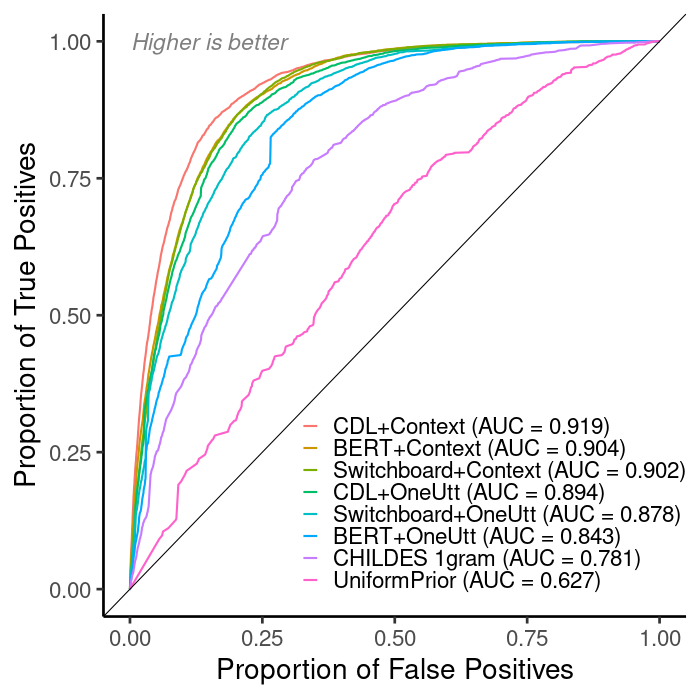

time: 2.37 s (started: 2022-06-15 07:00:37 -07:00)


In [28]:
%%R -h 700 -w 700
p1 = ggplot(scores_across_time_overview_set, 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname_with_wfst_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('../../output/figures/roc_wfst.pdf', height=10, width=10)    

### Set Color Standards for All Plots

In [29]:
%%R
g <- ggplot_build(p1)
colors_for_8_plots = unique(g$data[[1]]$colour)
reorder = c(1,3,2,4,5,6,7,8)
colors_for_8_plots = colors_for_8_plots[reorder]
print(colors_for_8_plots)

[1] "#F8766D" "#7CAE00" "#CD9600" "#00BE67" "#00BFC4" "#00A9FF" "#C77CFF"
[8] "#FF61CC"
time: 821 ms (started: 2022-06-15 07:00:39 -07:00)


In [30]:
%%R
models_for_8_plots = scores_per_model_wfst$model_shortname[reorder]
print(as.character(models_for_8_plots))
shapes_for_8_plots = c(19, 17,  7, 18, 4, 15, 3, 1)

[1] "CDL+Context"         "Switchboard+Context" "BERT+Context"       
[4] "CDL+OneUtt"          "Switchboard+OneUtt"  "BERT+OneUtt"        
[7] "CHILDES 1gram"       "UniformPrior"       
time: 21.7 ms (started: 2022-06-15 07:00:40 -07:00)


## Levenshtein Distance

In [31]:
%%R
auc_by_model_lev = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_levdist = auc(roc1)))}))

scores_across_time_short_lev = merge(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance') , auc_by_model_lev)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 41.8 s (started: 2022-06-15 07:00:40 -07:00)


In [32]:
%%R
# get rid of tags in the model shortname
scores_across_time_short_lev = filter_model_subset(scores_across_time_short_lev, overview_set)
scores_across_time_short_lev$model_shortname = gsub('\\+Tags','', scores_across_time_short_lev$model)
# we can do this because for each model with tags, there is no model without tags in the analysis set
scores_across_time_short_lev$model_with_levdist_auc = paste0(scores_across_time_short_lev$model_shortname,' (AUC = ',
round(scores_across_time_short_lev$auc_levdist, 3),')')

time: 3.68 s (started: 2022-06-15 07:01:22 -07:00)


In [33]:
%%R
scores_across_time_short_lev$model_with_levdist_auc = paste0(scores_across_time_short_lev$model_shortname,' (AUC = ',
round(scores_across_time_short_lev$auc_levdist, 3),')')

time: 3.42 s (started: 2022-06-15 07:01:25 -07:00)


In [34]:
%%R
# sort the levels by the scores
names_per_model = aggregate(model_with_levdist_auc ~ model_shortname, scores_across_time_short_lev, unique)
scores_per_model_lev = aggregate(auc_levdist ~ model_shortname, scores_across_time_short_lev, unique)
scores_per_model_lev = merge(names_per_model, scores_per_model_lev)
scores_per_model_lev = scores_per_model_lev[order(scores_per_model_lev$auc_levdist, decreasing=T),]
print(scores_per_model_lev)
scores_across_time_short_lev$model_with_levdist_auc = factor(as.character(scores_across_time_short_lev$model_with_levdist_auc), 
                                                             levels = as.character(scores_per_model_lev$model_with_levdist_auc))

      model_shortname            model_with_levdist_auc auc_levdist
3         CDL+Context         CDL+Context (AUC = 0.872)   0.8724673
1        BERT+Context        BERT+Context (AUC = 0.859)   0.8593691
6 Switchboard+Context Switchboard+Context (AUC = 0.846)   0.8460553
4          CDL+OneUtt          CDL+OneUtt (AUC = 0.835)   0.8350191
7  Switchboard+OneUtt  Switchboard+OneUtt (AUC = 0.813)   0.8127051
2         BERT+OneUtt         BERT+OneUtt (AUC = 0.788)   0.7878455
5       CHILDES 1gram       CHILDES 1gram (AUC = 0.664)   0.6638829
8        UniformPrior        UniformPrior (AUC = 0.657)   0.6569725
time: 1.92 s (started: 2022-06-15 07:01:29 -07:00)


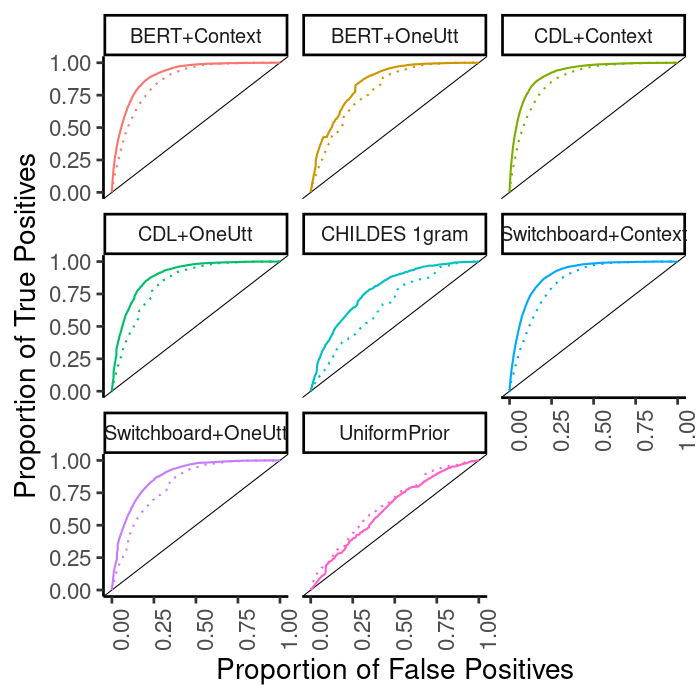

time: 5.1 s (started: 2022-06-15 07:01:31 -07:00)


In [35]:
%%R -h 700 -w 700
p1 = ggplot(filter_model_subset(scores_across_time_short_lev, overview_set), 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname), linetype = 'dashed'
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0, linetype="dotted") + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position="none", axis.text.x = element_text(angle = 90, hjust=1)
)  + geom_abline(intercept=0, slope=1
) + facet_wrap(~model_shortname) + geom_roc(data=filter_model_subset(scores_across_time_short_wfst,
overview_set), aes(d=set_binarized, 
m=posterior_entropy, color=model_shortname), n.cuts=0) + theme(strip.text.x = element_text(size = 20))
ggsave('../../output/figures/roc_levdist.pdf', height=10, width=10)   + scale_color_manual(
        values=colors_for_8_plots)  
print(p1)

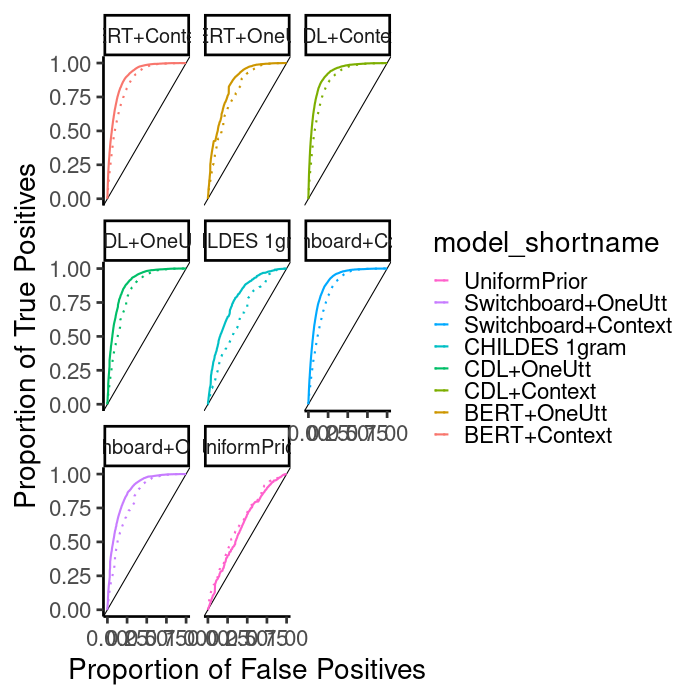

time: 2.73 s (started: 2022-06-15 07:01:36 -07:00)


In [36]:
%%R -h 700 -w 700
p1 = ggplot(filter_model_subset(scores_across_time_short_lev, overview_set), 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname), linetype = 'dashed'
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0, linetype="dotted") + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + geom_abline(intercept=0, slope=1
) + facet_wrap(~model_shortname) + geom_roc(data=filter_model_subset(scores_across_time_short_wfst,
overview_set), aes(d=set_binarized,  m=posterior_entropy, color=model_shortname), n.cuts=0) + theme(strip.text.x = element_text(size = 20)
) +  guides(color = guide_legend(reverse=TRUE))
print(p1)

## Visualization of Successes and Failures

In [37]:
%%R
index_cols = c('bert_token_id', 'set')
selected_cols = c('posterior_entropy', 'posterior_probability', 'posterior_rank', 'prior_entropy', 'prior_probability', 'prior_rank')
best_model = subset(scores_across_time_short, model == "CDL+Context+Tags" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(best_model) = c(index_cols, paste0('bert_', selected_cols))
base_model = subset(scores_across_time_short, model == "UniformPrior" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(base_model) = c(index_cols, paste0('uniform_', selected_cols))
model_scores_merged = merge(best_model, base_model)

time: 1.36 s (started: 2022-06-15 07:01:38 -07:00)


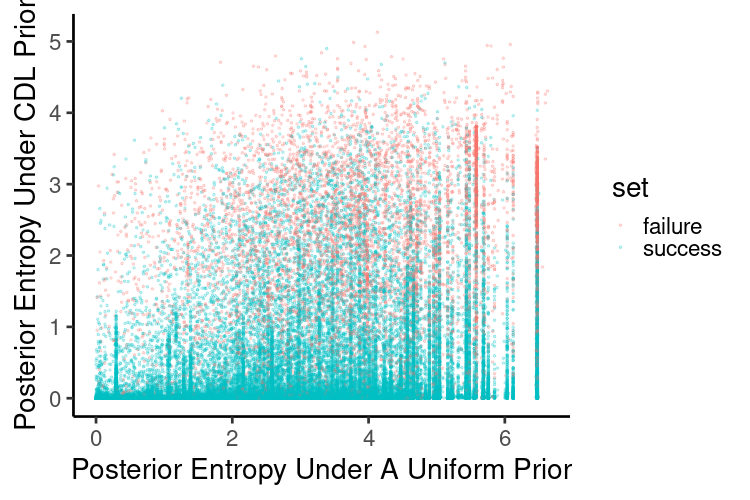

time: 919 ms (started: 2022-06-15 07:01:40 -07:00)


In [38]:
%%R -w 750 -h 500 
ggplot(model_scores_merged) + geom_point(aes(x=uniform_posterior_entropy, y=bert_posterior_entropy, color=set), alpha=.25, size=1
) + theme_classic(base_size=28) + xlab('Posterior Entropy Under A Uniform Prior') + ylab('Posterior Entropy Under CDL Prior')

## Statistical Tests for Difference in ROC curves

### Pairwise comparison of WFST ROC curves

In [39]:
%%R

models = unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model)
models[1]
roc_tests = mat.or.vec(length(models), length(models))

time: 341 ms (started: 2022-06-15 07:01:41 -07:00)


In [40]:
%%R
test = subset(scores_across_time_short, model == "Switchboard+Context" & likelihood_type == 'WFST')
nrow(test)

[1] 0
time: 82.5 ms (started: 2022-06-15 07:01:41 -07:00)


In [41]:
%%R
#precompute ROCs
rocs = list()
for (model_name in overview_set){
    print(model_name)
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    rocs[[model_name]] = roc(one_model$set_binarized, one_model$posterior_entropy)
}

[1] "CDL+Context+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "BERT+Context"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "CDL+OneUtt+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "BERT+OneUtt"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "Switchboard+Context+Tags"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "Switchboard+OneUtt"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "CHILDES 1gram"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



[1] "UniformPrior"


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



time: 1.69 s (started: 2022-06-15 07:01:41 -07:00)


In [42]:
%%R

roc_ps = mat.or.vec(length(overview_set), length(overview_set))
roc_stats = mat.or.vec(length(overview_set), length(overview_set))



for (i in c(1:length(overview_set))){
    for (j in c(1:i)){
        roc1 = rocs[[overview_set[i]]]
        roc2 = rocs[[overview_set[j]]]
        rtest = roc.test(roc1, roc2, method="delong")
        roc_ps[i,j] = round(rtest$p.value, 3)        
        roc_stats [i,j] = abs(round(rtest$statistic, 3))        
    }
}    


roc_ps = data.frame(roc_ps)
names(roc_ps) = overview_set
colnames(roc_ps) = overview_set


roc_stats = data.frame(roc_stats)
names(roc_stats) = overview_set
colnames(roc_stats) = overview_set

time: 584 ms (started: 2022-06-15 07:01:43 -07:00)


In [43]:
%%R

roc_stats

  CDL+Context+Tags BERT+Context CDL+OneUtt+Tags BERT+OneUtt
1            0.000        0.000           0.000       0.000
2            9.736        0.000           0.000       0.000
3           17.108        6.282           0.000       0.000
4           35.014       35.171          25.895       0.000
5           12.596        1.556           4.982      28.654
6           22.445       16.889          10.863      24.544
7           43.750       38.853          35.252      18.113
8           77.049       73.217          69.401      54.006
  Switchboard+Context+Tags Switchboard+OneUtt CHILDES 1gram UniformPrior
1                    0.000              0.000         0.000            0
2                    0.000              0.000         0.000            0
3                    0.000              0.000         0.000            0
4                    0.000              0.000         0.000            0
5                    0.000              0.000         0.000            0
6                   15

In [44]:
%%R
roc_ps

  CDL+Context+Tags BERT+Context CDL+OneUtt+Tags BERT+OneUtt
1                1         0.00               0           0
2                0         1.00               0           0
3                0         0.00               1           0
4                0         0.00               0           1
5                0         0.12               0           0
6                0         0.00               0           0
7                0         0.00               0           0
8                0         0.00               0           0
  Switchboard+Context+Tags Switchboard+OneUtt CHILDES 1gram UniformPrior
1                        0                  0             0            0
2                        0                  0             0            0
3                        0                  0             0            0
4                        0                  0             0            0
5                        1                  0             0            0
6                     

In [45]:
%%R
roc_stats[5,2] = NA
print(min(roc_stats[roc_stats > 0], na.rm=T))
print(max(roc_stats[roc_stats > 0], na.rm=T))

[1] 4.982
[1] 77.049
time: 7.48 ms (started: 2022-06-15 07:01:44 -07:00)


In [46]:
%%R
roc_ps[5,2] = NA
print(min(roc_ps[roc_ps < 1], na.rm=T))
print(max(roc_ps[roc_ps < 1], na.rm=T))

[1] 0
[1] 0
time: 9.6 ms (started: 2022-06-15 07:01:44 -07:00)


### Paired Comparison of Likelihoods Within Model

In [47]:
%%R
#precompute ROCs
levdist_rocs = list()
for (model_name in overview_set){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    levdist_rocs[[model_name]] = roc(one_model$set_binarized, one_model$posterior_entropy)
}

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



time: 1.52 s (started: 2022-06-15 07:01:44 -07:00)


In [48]:
%%R
paired_comparison =  do.call('rbind', lapply(overview_set, function(model_name){    
    roc1 = rocs[[model_name]]
    roc2 = levdist_rocs[[model_name]]
    rtest = roc.test(roc1, roc2, method="delong")    

    prob = round(rtest$p.value, 3)        
    stat = abs(round(rtest$statistic, 3))    
    return(data.frame(model_name, prob, stat))        
}))

paired_comparison

                 model_name prob   stat
D          CDL+Context+Tags    0 18.320
D1             BERT+Context    0 17.351
D2          CDL+OneUtt+Tags    0 21.193
D3              BERT+OneUtt    0 16.791
D4 Switchboard+Context+Tags    0 21.545
D5       Switchboard+OneUtt    0 21.506
D6            CHILDES 1gram    0 27.436
D7             UniformPrior    0  6.159
time: 155 ms (started: 2022-06-15 07:01:45 -07:00)


In [49]:
%%R
print(auc(rocs[['UniformPrior']]))
print(auc(levdist_rocs[['UniformPrior']]))

Area under the curve: 0.6272
Area under the curve: 0.657
time: 17.1 ms (started: 2022-06-15 07:01:45 -07:00)


In [50]:
%%R
roc.test(rocs[['UniformPrior']], levdist_rocs[['UniformPrior']], method="delong") 


	DeLong's test for two ROC curves

data:  rocs[["UniformPrior"]] and levdist_rocs[["UniformPrior"]]
D = -6.1586, df = 101528, p-value = 7.364e-10
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.6272221   0.6569725 

time: 48.7 ms (started: 2022-06-15 07:01:45 -07:00)


# Analysis 2: Do the models find the same words as adults?

## Prior and Posterior Table

In [51]:
%%R
unique(successes_across_time$likelihood_type)

[1] "Levenshtein Distance" "WFST"                
time: 38.3 ms (started: 2022-06-15 07:01:45 -07:00)


### WFST

In [52]:
%%R
# note that we don't need to separate the prior computations by the likelihood type-- it's the prior!

prior_probs = aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})
posterior_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){mean(-1 * log(x, base = 2))})
prior_probs = merge(prior_probs, posterior_probs)
    

subset(prior_probs, model %in% overview_set)

                      model prior_probability posterior_probability
1              BERT+Context          4.626855             1.0244256
2               BERT+OneUtt          7.347527             1.8142604
4          CDL+Context+Tags          3.301907             0.6283817
10          CDL+OneUtt+Tags          5.059460             1.0923931
15            CHILDES 1gram          8.790043             2.2592094
16 Switchboard+Context+Tags          4.096072             0.8492632
17       Switchboard+OneUtt          6.462003             1.5190849
18             UniformPrior         12.965243             4.6138573
time: 1.08 s (started: 2022-06-15 07:01:45 -07:00)


In [53]:
%%R
posterior_probs_sd = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){sem(-1 * log(x, base = 2))})
names(posterior_probs_sd) = c('model', 'posterior_probability_sem')


prior_probs_sem = aggregate(prior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){sem(-1 * log(x, base = 2))})
names(prior_probs_sem) = c('model', 'prior_probability_sem')

prior_probs = merge(merge(prior_probs, posterior_probs_sd), prior_probs_sem)
prior_probs = prior_probs[order(prior_probs$prior_probability),]
prior_probs$prior_low = prior_probs$prior_probability - prior_probs$prior_probability_sem
prior_probs$prior_high = prior_probs$prior_probability + prior_probs$prior_probability_sem
prior_probs$posterior_low = prior_probs$posterior_probability - prior_probs$posterior_probability_sem
prior_probs$posterior_high = prior_probs$posterior_probability + prior_probs$posterior_probability_sem
prior_probs


                      model prior_probability posterior_probability
4          CDL+Context+Tags          3.301907             0.6283817
6    CDL+Older+Context+Tags          3.319319             0.6360412
3               CDL+Context          3.387972             0.6395481
5         CDL+Older+Context          3.389654             0.6614732
12 CDL+Younger+Context+Tags          3.488081             0.6630180
11      CDL+Younger+Context          3.493721             0.6547977
16 Switchboard+Context+Tags          4.096072             0.8492632
1              BERT+Context          4.626855             1.0244256
10          CDL+OneUtt+Tags          5.059460             1.0923931
8     CDL+Older+OneUtt+Tags          5.064600             1.1016046
9                CDL+OneUtt          5.169880             1.1154794
7          CDL+Older+OneUtt          5.241232             1.1315326
13       CDL+Younger+OneUtt          5.372199             1.1557221
14  CDL+Younger+OneUtt+Tags          5.380850   

In [54]:
%%R
# try bootstrapping it instead
library(boot)

fc <- function(x,i ){
	return(mean(x[i]))
}

x = rnorm(1000)
print(x[1:10])
boot.ci(boot(x, fc, R=1000), type="basic")$basic[,4:5]

# get the 95% ci

 [1] -0.6692361 -0.6906231 -0.6858706  0.2347277 -0.5560515  0.6008730
 [7]  0.5946443 -1.2751095 -0.8855613 -1.5981173
[1] -0.10010564  0.01714775
time: 120 ms (started: 2022-06-15 07:01:48 -07:00)


In [55]:
%%R
library('parallel')
fc <- function(x,i ){
	return(mean(x[i]))
}

wfst_df = subset(successes_across_time, likelihood_type == 'WFST')
df_split = split(wfst_df, wfst_df$model) 
results = do.call('rbind', mclapply(df_split, function(df){
    x = -1 * log(df$prior_probability, base = 2)
    ci = boot.ci(boot(x, fc, R=10), type="basic")$basic
    return(data.frame(model = unique(df$model), low=ci[4], high=ci[5]))
}, mc.cores=24))



time: 31.7 s (started: 2022-06-15 07:01:48 -07:00)


In [56]:
%%R
posterior_mean_rankings = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){mean_posterior_rank = mean(x)})
names(posterior_mean_rankings) = c('model', 'likelihood_type', 'mean_posterior_rank')

prior_mean_rankings = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){mean_prior_rank = mean(x)})
names(prior_mean_rankings) = c('model', 'likelihood_type', 'mean_prior_rank')

prior_top1 = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){prior_percenttop1 = mean(x ==  0)})
names(prior_top1) = c('model', 'likelihood_type', 'prior_percenttop1')

posterior_median_rankings = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){median_posterior_rank = median(x)+1})
names(posterior_median_rankings) = c('model', 'likelihood_type', 'median_posterior_rank')
# 0-indexed coming from Python, so incrementing by one


prior_median_rankings = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){median_prior_rank = median(x)+1})
names(prior_median_rankings) = c('model', 'likelihood_type', 'median_prior_rank')
# 0-indexed coming from Pythong, so incrementing by one

top_1 = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){percenttop1 = mean(x ==  0)})
names(top_1) = c('model', 'likelihood_type','percenttop1')


rankings = merge(merge(merge(prior_mean_rankings, posterior_mean_rankings, 
    by=c('model', 'likelihood_type')), top_1), prior_top1)

rankings = merge(rankings, posterior_median_rankings, by=c('model', 'likelihood_type'))
rankings = merge(rankings, prior_median_rankings, by=c('model', 'likelihood_type'))





rankings = rankings[order(rankings$mean_prior_rank),]
subset(rankings, model %in% overview_set)

                      model      likelihood_type mean_prior_rank
7          CDL+Context+Tags Levenshtein Distance         50.2067
8          CDL+Context+Tags                 WFST         50.2067
31 Switchboard+Context+Tags Levenshtein Distance        110.4598
32 Switchboard+Context+Tags                 WFST        110.4598
19          CDL+OneUtt+Tags Levenshtein Distance        124.3078
20          CDL+OneUtt+Tags                 WFST        124.3078
1              BERT+Context Levenshtein Distance        140.9874
2              BERT+Context                 WFST        140.9874
29            CHILDES 1gram Levenshtein Distance        314.0850
30            CHILDES 1gram                 WFST        314.0850
33       Switchboard+OneUtt Levenshtein Distance        362.9005
34       Switchboard+OneUtt                 WFST        362.9005
3               BERT+OneUtt Levenshtein Distance        494.1773
4               BERT+OneUtt                 WFST        494.1773
35             UniformPri

In [57]:
%%R
for_table = subset(merge(prior_probs, rankings, all.x=T), model %in% overview_set)
for_table
for_table$prior_probability = round(for_table$prior_probability, 2)
for_table$posterior_probability = round(for_table$posterior_probability, 2)
for_table$prior_percenttop1 = round(for_table$prior_percenttop1, 2)
for_table$mean_prior_rank = round(for_table$mean_prior_rank, 2)
for_table$mean_posterior_rank = round(for_table$mean_posterior_rank, 2)
for_table$percenttop1 = round(for_table$percenttop1, 2)
#for_table = for_table[order(for_table$prior_probability),]

table_for_writing =  subset(for_table, likelihood_type == "WFST")[,c('model','prior_probability','mean_prior_rank', 'prior_percenttop1', 'posterior_probability','mean_posterior_rank','percenttop1')]
names(table_for_writing) = c('Model', 'Prior Surprisal (bits)', 'Mean Prior Rank', 'Prior Proportion of Top-1 Guesses', 'Posterior Surprisal (bits)', 'Mean Posterior Rank', 'Proportion of Top-1 Guesses')
table_for_writing

                      Model Prior Surprisal (bits) Mean Prior Rank
2              BERT+Context                   4.63          140.99
4               BERT+OneUtt                   7.35          494.18
8          CDL+Context+Tags                   3.30           50.21
20          CDL+OneUtt+Tags                   5.06          124.31
30            CHILDES 1gram                   8.79          314.09
32 Switchboard+Context+Tags                   4.10          110.46
34       Switchboard+OneUtt                   6.46          362.90
36             UniformPrior                  12.97         3998.00
   Prior Proportion of Top-1 Guesses Posterior Surprisal (bits)
2                               0.45                       1.02
4                               0.25                       1.81
8                               0.55                       0.63
20                              0.36                       1.09
30                              0.03                       2.26
32           

In [58]:
%%R
write.csv(for_table, '../../output/csv/surprisal_table.csv', row.names=F)

time: 4.21 ms (started: 2022-06-15 07:02:25 -07:00)


In [59]:
%%R
unique(for_table$likelihood_type)

[1] "Levenshtein Distance" "WFST"                
time: 14.6 ms (started: 2022-06-15 07:02:25 -07:00)


In [60]:
%%R
table_for_writing =  subset(for_table, likelihood_type == "Levenshtein Distance")[,c('model','posterior_probability','mean_posterior_rank','percenttop1')]
names(table_for_writing) = c('Model', 'Posterior Surprisal (bits)', 'Mean Posterior Rank', 'Proportion of Top-1 Guesses' )
table_for_writing

                      Model Posterior Surprisal (bits) Mean Posterior Rank
1              BERT+Context                       1.02               18.52
3               BERT+OneUtt                       1.81               46.50
7          CDL+Context+Tags                       0.63                7.89
19          CDL+OneUtt+Tags                       1.09               23.37
29            CHILDES 1gram                       2.26               49.00
31 Switchboard+Context+Tags                       0.85               13.95
33       Switchboard+OneUtt                       1.52               42.93
35             UniformPrior                       4.61              138.31
   Proportion of Top-1 Guesses
1                         0.76
3                         0.66
7                         0.83
19                        0.74
29                        0.51
31                        0.78
33                        0.68
35                        0.32
time: 42.2 ms (started: 2022-06-15 07:02:25 -0

In [61]:
%%R
nrow(for_table)

[1] 16
time: 5.79 ms (started: 2022-06-15 07:02:25 -07:00)


In [62]:
%%R
as.character(subset(for_table, likelihood_type == 'WFST')$model)

[1] "BERT+Context"             "BERT+OneUtt"             
[3] "CDL+Context+Tags"         "CDL+OneUtt+Tags"         
[5] "CHILDES 1gram"            "Switchboard+Context+Tags"
[7] "Switchboard+OneUtt"       "UniformPrior"            
time: 17.9 ms (started: 2022-06-15 07:02:25 -07:00)


R[write to console]: Saving 6.67 x 6.67 in image



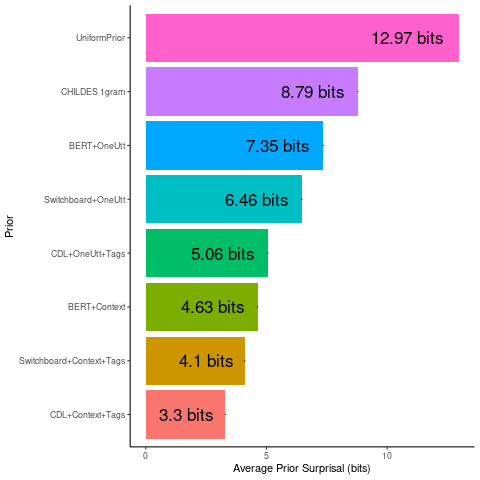

time: 352 ms (started: 2022-06-15 07:02:25 -07:00)


In [63]:
%%R
table_for_ordering = subset(for_table, likelihood_type == 'WFST')
table_for_ordering = table_for_ordering[order(table_for_ordering$prior_probability),]

for_table$model  = factor(for_table$model, levels = table_for_ordering$model)
for_table$prior_probability_bits = paste(for_table$prior_probability, 'bits')

p1 =  ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=prior_probability, fill=model), stat="identity"
) + coord_flip() + ylab('Average Prior Surprisal (bits)') + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_errorbar(aes(x=model, ymin=prior_low, ymax = prior_high), width = 0
)+  geom_text(aes(x=model, y=prior_probability, label=prior_probability_bits), hjust=1.2, size=6
) 
print(p1)

ggsave('../../output/figures/prior_bar_chart.pdf')

R[write to console]: Saving 6.67 x 6.67 in image



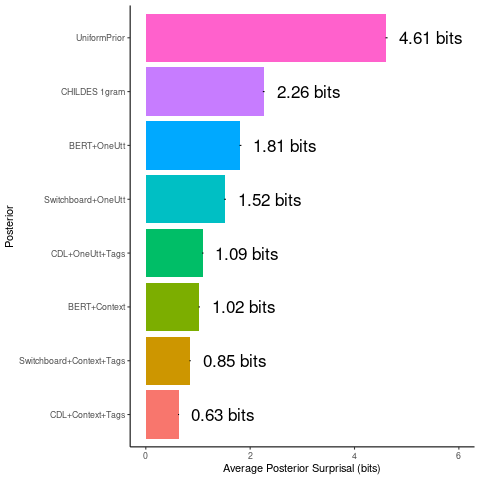

time: 249 ms (started: 2022-06-15 07:02:26 -07:00)


In [64]:
%%R
for_table$posterior_probability_bits = paste(for_table$posterior_probability, 'bits')

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=posterior_probability, fill=model), stat="identity"
)  + ylab('Average Posterior Surprisal (bits)') + xlab('Posterior') + theme_classic() +
theme(legend.position="none") + geom_errorbar(aes(x=model, ymin=posterior_low, ymax = posterior_high), width = 0
)+  geom_text(aes(x=model, y=posterior_probability, label=posterior_probability_bits), hjust=-.2, size=6
)  + coord_flip(ylim=c(0, 6))

print(p1)
ggsave('../../output/figures/posterior_bar_chart.pdf')

R[write to console]: Saving 6.67 x 6.67 in image



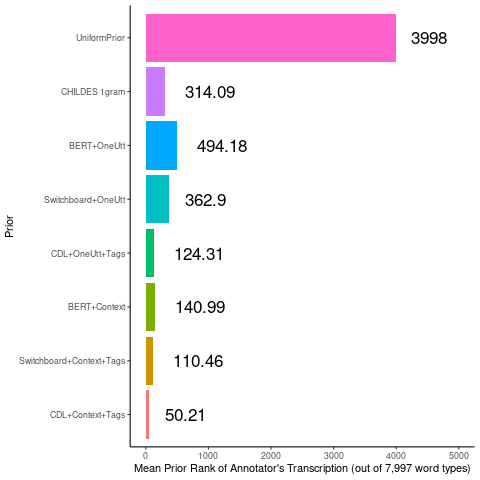

time: 188 ms (started: 2022-06-15 07:02:26 -07:00)


In [65]:
%%R
p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=mean_prior_rank, fill=model), stat="identity"
)  + ylab("Mean Prior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=mean_prior_rank, label=mean_prior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 5000)) 
print(p1)
ggsave('../../output/figures/prior_rank.pdf')


R[write to console]: Saving 6.67 x 6.67 in image



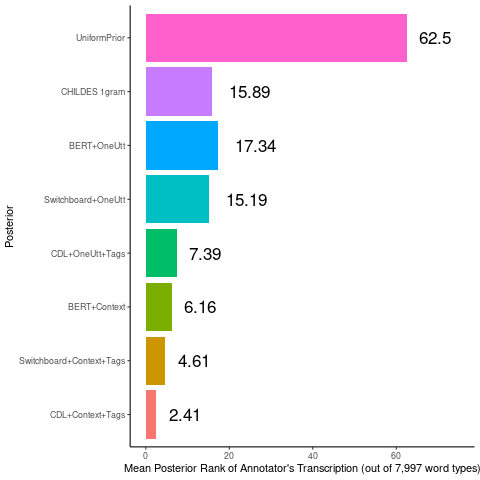

time: 200 ms (started: 2022-06-15 07:02:26 -07:00)


In [66]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=mean_posterior_rank, fill=model), stat="identity"
)  + ylab("Mean Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Posterior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=mean_posterior_rank, label=mean_posterior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 75)) 
print(p1)
ggsave('../../output/figures/posterior_rank.pdf')

### Compare Likelihood Functions

R[write to console]: Saving 6.67 x 6.67 in image



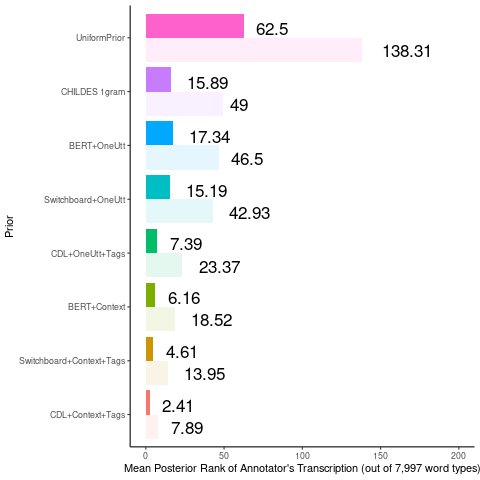

time: 327 ms (started: 2022-06-15 07:02:26 -07:00)


In [67]:
%%R
library(ggpattern)

p1 = ggplot(for_table) + geom_bar(aes(x=model, y=mean_posterior_rank, fill=model, alpha=likelihood_type), stat="identity", position="dodge"
)  + ylab("Mean Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(data=subset(for_table, likelihood_type =='WFST'), aes(x=model, y=mean_posterior_rank, 
label=mean_posterior_rank), hjust=-.4, size=6, vjust=-.2,                                          
position = "dodge") + geom_text(data=subset(for_table, likelihood_type =='Levenshtein Distance'), aes(x=model, y=mean_posterior_rank, 
label=mean_posterior_rank), hjust=-.4, size=6, vjust=1.5,                                          
position = "dodge")  + coord_flip(ylim =c(0, 200)) 
print(p1)
ggsave('../../output/figures/posterior_rank_by_likelihood.pdf')

### Median Ranks

In [68]:
%%R
# aggregate number by rank by mode
number_by_rank_by_model = aggregate(posterior_probability ~ posterior_rank + model,
    subset(successes_across_time, likelihood_type == 'WFST') , length) 
names(number_by_rank_by_model) = c('posterior_rank' , 'model', 'number_items')

number_by_rank_by_model = subset(number_by_rank_by_model, model %in% overview_set)
number_by_rank_by_model$model  = factor(number_by_rank_by_model$model, levels = table_for_ordering$model)


time: 1.09 s (started: 2022-06-15 07:02:27 -07:00)


R[write to console]: Saving 6.67 x 6.67 in image



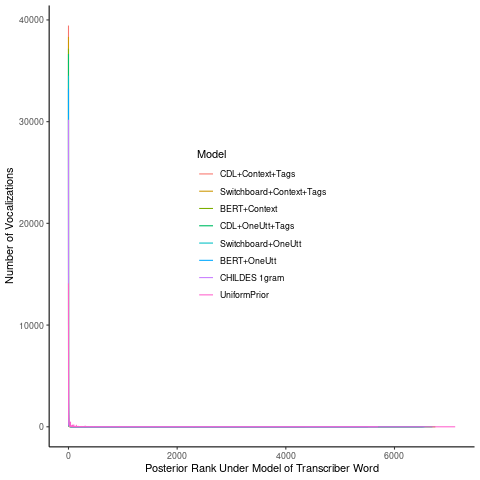

time: 432 ms (started: 2022-06-15 07:02:28 -07:00)


In [69]:
%%R
p1 = ggplot(number_by_rank_by_model) + geom_line(aes(
 x=posterior_rank, y = number_items, color=model))  + theme_classic(
) + ylab('Number of Vocalizations') + xlab('Posterior Rank Under Model of Transcriber Word'
) + theme(legend.position = c(.5, .5)) + labs(color='Model')
ggsave('../../output/figures/density_posterior_rank_full.pdf')
print(p1)

R[write to console]: Saving 6.67 x 6.67 in image



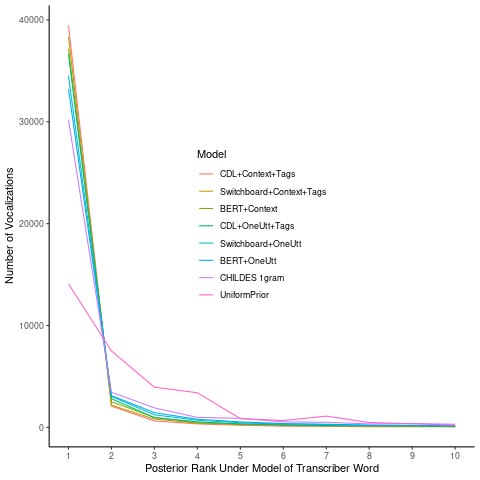

time: 334 ms (started: 2022-06-15 07:02:28 -07:00)


In [70]:
%%R
p1 = ggplot(subset(number_by_rank_by_model,
posterior_rank <= 9)) + geom_line(aes(
 x=posterior_rank+1, y = number_items, color=model))  + theme_classic(
) + ylab('Number of Vocalizations') + xlab('Posterior Rank Under Model of Transcriber Word'
) + theme(legend.position = c(.5, .5)) + labs(color='Model') + scale_x_continuous(
    breaks = c(1:10), labels = c(1:10))
ggsave('../../output/figures/density_posterior_rank_10.pdf')
print(p1)

R[write to console]: Saving 6.67 x 6.67 in image



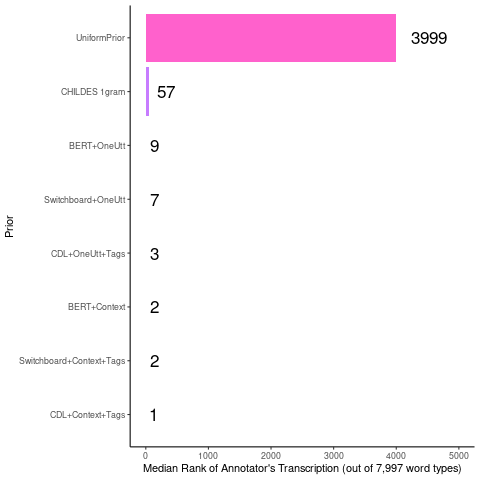

time: 187 ms (started: 2022-06-15 07:02:28 -07:00)


In [71]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=median_prior_rank, fill=model), stat="identity"
)  + ylab("Median Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=median_prior_rank, label=median_prior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 5000)) 
print(p1)
ggsave('../../output/figures/median_prior_rank.pdf')



R[write to console]: Saving 6.67 x 6.67 in image



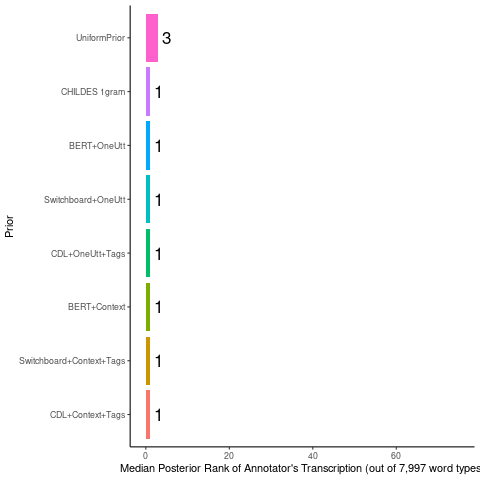

time: 226 ms (started: 2022-06-15 07:02:29 -07:00)


In [72]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=median_posterior_rank, fill=model), stat="identity"
)  + ylab("Median Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=median_posterior_rank, label=median_posterior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 75)) 
print(p1)
ggsave('../../output/figures/median_posterior_rank.pdf')

### Levenshtein Distance (Posteriors Only)

In [73]:
%%R

lev_top_1

R[write to console]: Error in withVisible({ : object 'lev_top_1' not found

R[write to console]: In addition: 
R[write to console]: There were 16 warnings (use warnings() to see them)
R[write to console]: 




Error in withVisible({ : object 'lev_top_1' not found
time: 7.03 ms (started: 2022-06-15 07:02:29 -07:00)


In [74]:
%%R
lev_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean(-1 * log(x, base = 2))})
lev_rankings = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean_posterior_rank = mean(x)})
names(lev_rankings) = c('model', 'mean_posterior_rank')
lev_top_1 = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean_posterior_rank = mean(x ==  0)})
names(lev_top_1) = c('model', 'percenttop1')
lev_for_table = subset(merge(merge(lev_probs, lev_rankings, all.x=T), lev_top_1), model %in% overview_set)
lev_for_table[order(lev_for_table$posterior_probability),]

                      model posterior_probability mean_posterior_rank
4          CDL+Context+Tags              1.151873            7.886872
16 Switchboard+Context+Tags              1.520166           13.949501
1              BERT+Context              1.691454           18.517299
10          CDL+OneUtt+Tags              1.900132           23.373504
17       Switchboard+OneUtt              2.533751           42.926535
2               BERT+OneUtt              2.832998           46.503691
15            CHILDES 1gram              3.762499           48.995139
18             UniformPrior              4.965982          138.308080
   percenttop1
4    0.8254015
16   0.7839440
1    0.7627723
10   0.7373072
17   0.6757684
2    0.6635015
15   0.5128234
18   0.3210513
time: 1.6 s (started: 2022-06-15 07:02:29 -07:00)


In [75]:
%%R
lev_for_table$percenttop1

[1] 0.7627723 0.6635015 0.8254015 0.7373072 0.5128234 0.7839440 0.6757684
[8] 0.3210513
time: 17.4 ms (started: 2022-06-15 07:02:30 -07:00)


In [76]:
%%R
lev_for_table$posterior_probability = round(lev_for_table$posterior_probability, 2)
lev_for_table$mean_posterior_rank = round(lev_for_table$mean_posterior_rank, 2)
lev_for_table$percent_top_1 = round(lev_for_table$percenttop1, 2)
lev_for_table = lev_for_table[,c('model','posterior_probability','mean_posterior_rank', 'percent_top_1')]
lev_for_table =  lev_for_table[order(lev_for_table$posterior_probability),]
names(lev_for_table) = c('Model', 'Posterior Surprisal (bits)', 'Mean Posterior Rank','Percent Top-1 Guess')
lev_for_table

                      Model Posterior Surprisal (bits) Mean Posterior Rank
4          CDL+Context+Tags                       1.15                7.89
16 Switchboard+Context+Tags                       1.52               13.95
1              BERT+Context                       1.69               18.52
10          CDL+OneUtt+Tags                       1.90               23.37
17       Switchboard+OneUtt                       2.53               42.93
2               BERT+OneUtt                       2.83               46.50
15            CHILDES 1gram                       3.76               49.00
18             UniformPrior                       4.97              138.31
   Percent Top-1 Guess
4                 0.83
16                0.78
1                 0.76
10                0.74
17                0.68
2                 0.66
15                0.51
18                0.32
time: 53.3 ms (started: 2022-06-15 07:02:31 -07:00)


In [77]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

successes_across_time_wide =  spread(successes_across_time[,c('model','prior_probability',
'bert_token_id','likelihood_type')], model, prior_probability)
successes_across_time_wide = subset(successes_across_time_wide, likelihood_type == 'WFST')
head(successes_across_time_wide)

   bert_token_id likelihood_type BERT+Context  BERT+OneUtt  CDL+Context
2          10577            WFST 3.667992e-06 6.627167e-05 8.410694e-07
4          39428            WFST 2.478826e-04 1.482735e-04 4.409806e-04
6          39594            WFST 1.482284e-02 1.482735e-04 2.243443e-01
8          41265            WFST 7.339016e-01 2.187236e-02 7.561503e-01
10         41266            WFST 3.372385e-01 3.032036e-04 3.089629e-01
12         41756            WFST 6.015850e-06 3.048956e-06 8.208628e-06
   CDL+Context+Tags CDL+Older+Context CDL+Older+Context+Tags CDL+Older+OneUtt
2      3.087818e-06      3.598957e-06           1.023286e-05     0.0002718783
4      1.382378e-03      9.209570e-04           4.625310e-04     0.0029664957
6      8.003053e-01      5.187610e-01           7.900530e-01     0.0029664957
8      4.111795e-01      8.682773e-01           7.603316e-01     0.3416962028
10     2.215365e-01      4.889882e-01           1.467125e-01     0.0050733858
12     6.513209e-05      3.4

In [78]:
%%R

model_names = overview_set
print('Model names:')
print(model_names)

for (model_name in model_names){
    successes_across_time_wide[[model_name]] = as.numeric(successes_across_time_wide[[model_name]])
}

successes_across_time_wide_nona = drop_na(successes_across_time_wide)
print(dim(successes_across_time_wide_nona))

[1] "Model names:"
[1] "CDL+Context+Tags"         "BERT+Context"            
[3] "CDL+OneUtt+Tags"          "BERT+OneUtt"             
[5] "Switchboard+Context+Tags" "Switchboard+OneUtt"      
[7] "CHILDES 1gram"            "UniformPrior"            
[1] 44021    20
time: 29.8 ms (started: 2022-06-15 07:02:31 -07:00)


In [79]:
%%R
unique(successes_across_time_wide_nona$likelihood_type)

[1] "WFST"
time: 8.06 ms (started: 2022-06-15 07:02:31 -07:00)


### t-test Pairwise Model Comparison for WFST

In [80]:
%%R
#Pairwise paired t-test between all of the models with WFST only

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rval = t.test(
                successes_across_time_wide_nona[[model_name]], 
                successes_across_time_wide_nona[[comparison_model_name]],
              paired=T)$p.value
            rvs[model_idx, comparison_model_idx] = rval
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

                         CDL+Context+Tags BERT+Context CDL+OneUtt+Tags
CDL+Context+Tags                       NA            0               0
BERT+Context                            0           NA               0
CDL+OneUtt+Tags                         0            0              NA
BERT+OneUtt                             0            0               0
Switchboard+Context+Tags                0            0               0
Switchboard+OneUtt                      0            0               0
CHILDES 1gram                           0            0               0
UniformPrior                            0            0               0
                           BERT+OneUtt Switchboard+Context+Tags
CDL+Context+Tags          0.000000e+00                        0
BERT+Context              0.000000e+00                        0
CDL+OneUtt+Tags           0.000000e+00                        0
BERT+OneUtt                         NA                        0
Switchboard+Context+Tags  0.000000e+00   

### Prior Surprisal Across Ages Plots

In [81]:
%R mean_surprisal_by_age = aggregate(prior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model', 'likelihood_type','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood_type','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,likelihood_type,prior_surprisal_mean,prior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,7.274761,0.115150
2,1.0,BERT+Context,WFST,7.274761,0.115150
3,1.0,BERT+OneUtt,Levenshtein Distance,11.540593,0.109994
4,1.0,BERT+OneUtt,WFST,11.540593,0.109994
5,1.0,CDL+Context,Levenshtein Distance,4.057722,0.105941
...,...,...,...,...,...
212,3.5,Switchboard+Context+Tags,WFST,3.559659,0.082072
213,3.5,Switchboard+OneUtt,Levenshtein Distance,5.060470,0.091788
214,3.5,Switchboard+OneUtt,WFST,5.060470,0.091788
215,3.5,UniformPrior,Levenshtein Distance,12.965243,0.000000


time: 4.64 s (started: 2022-06-15 07:02:32 -07:00)


In [82]:
%%R
overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

time: 33.6 ms (started: 2022-06-15 07:02:36 -07:00)


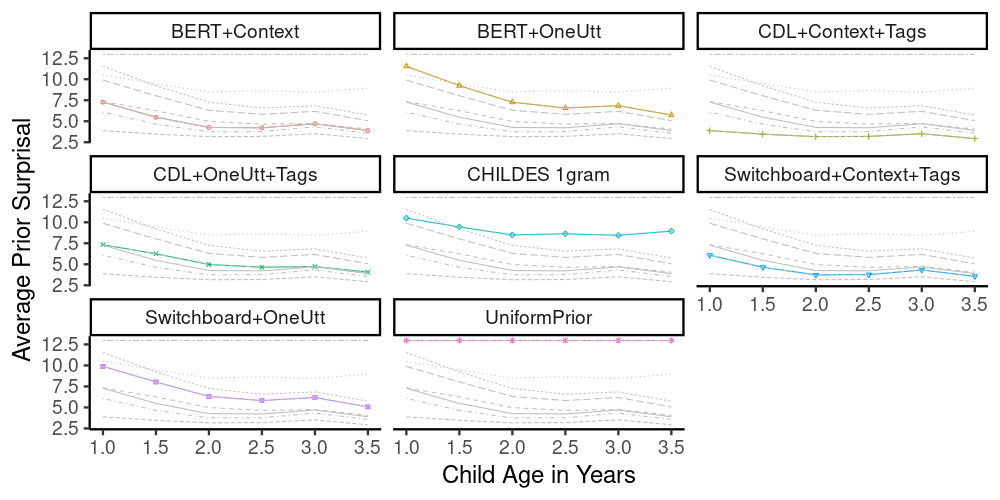

time: 607 ms (started: 2022-06-15 07:02:36 -07:00)


In [83]:
%%R -w 1000 -h 500
ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none') + scale_shape_manual(values=1:nlevels(as.factor(overview_mean_surprisal_by_age$model))
    ) + scale_color_discrete()

# # Best performing CDL Context all/all, CHILDES 1gram and Uniform Prior 

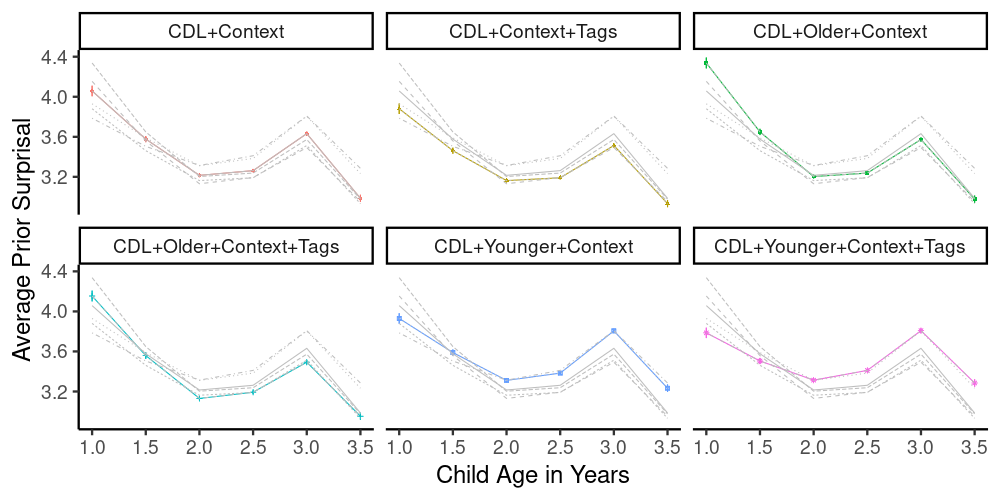

time: 566 ms (started: 2022-06-15 07:02:37 -07:00)


In [84]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')



## Posterior

In [85]:
%R mean_surprisal_by_age = aggregate(posterior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','likelihood','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
#%R print(mean_surprisal_by_age)

,age,model,likelihood,posterior_surprisal_mean,posterior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,4.338195,0.114457
2,1.0,BERT+Context,WFST,2.877891,0.095620
3,1.0,BERT+OneUtt,Levenshtein Distance,7.319938,0.151035
4,1.0,BERT+OneUtt,WFST,5.117900,0.126537
5,1.0,CDL+Context,Levenshtein Distance,2.334840,0.087965
...,...,...,...,...,...
212,3.5,Switchboard+Context+Tags,WFST,0.392354,0.030414
213,3.5,Switchboard+OneUtt,Levenshtein Distance,1.260790,0.058068
214,3.5,Switchboard+OneUtt,WFST,0.724214,0.040052
215,3.5,UniformPrior,Levenshtein Distance,3.708417,0.070411


time: 4.33 s (started: 2022-06-15 07:02:38 -07:00)


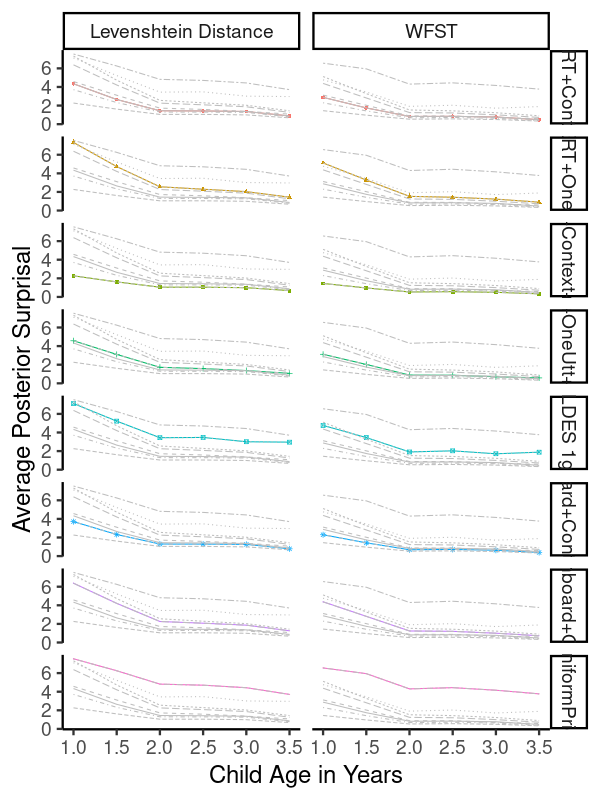

time: 831 ms (started: 2022-06-15 07:02:42 -07:00)


In [86]:
%%R -w 600 -h 800

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_grid(model~likelihood) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


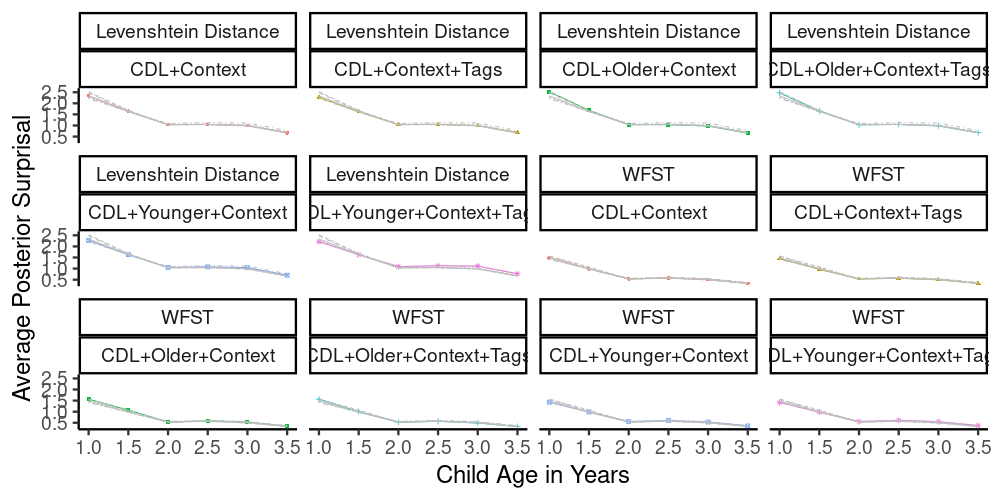

time: 894 ms (started: 2022-06-15 07:02:43 -07:00)


In [87]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(likelihood~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


In [88]:
%%R
unique(as.character(mean_surprisal_by_age$model))

 [1] "BERT+Context"             "BERT+OneUtt"             
 [3] "CDL+Context"              "CDL+Context+Tags"        
 [5] "CDL+Older+Context"        "CDL+Older+Context+Tags"  
 [7] "CDL+Older+OneUtt"         "CDL+Older+OneUtt+Tags"   
 [9] "CDL+OneUtt"               "CDL+OneUtt+Tags"         
[11] "CDL+Younger+Context"      "CDL+Younger+Context+Tags"
[13] "CDL+Younger+OneUtt"       "CDL+Younger+OneUtt+Tags" 
[15] "CHILDES 1gram"            "Switchboard+Context+Tags"
[17] "Switchboard+OneUtt"       "UniformPrior"            
time: 41.1 ms (started: 2022-06-15 07:02:44 -07:00)


In [89]:
%%R
mean_surprisal_by_age$model_shortname = gsub('\\+Tags', '', mean_surprisal_by_age$model)

time: 8.72 ms (started: 2022-06-15 07:02:44 -07:00)


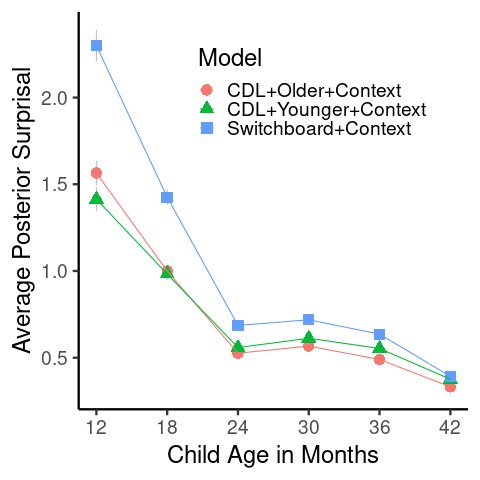

time: 357 ms (started: 2022-06-15 07:02:44 -07:00)


In [90]:
%%R 

selected_models = c('CDL+Younger+Context+Tags', 'CDL+Older+Context+Tags',
                   'Switchboard+Context+Tags')

mean_surprisal_by_age$age_in_months = mean_surprisal_by_age$age * 12

p1 =  ggplot(subset(mean_surprisal_by_age, likelihood == 'WFST' &  model %in% selected_models)
    ) + geom_errorbar(aes(x=age_in_months, ymin=posterior_surprisal_mean - posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + posterior_surprisal_sem), color="gray",  width=0) + geom_point(aes(
    x=age_in_months, y=posterior_surprisal_mean, color=model_shortname,
    shape = model_shortname), size=5) + geom_line(aes(x=age_in_months, y=posterior_surprisal_mean, color=model_shortname)
    )  + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Months') + theme(
    legend.position=c(.6, .8))  +  guides(shape = guide_legend(title = "Model"), color = guide_legend(title = "Model")
    ) + scale_x_continuous( breaks = seq(from=6, to=48, by=6), labels= seq(from=6, to=48, by=6))

ggsave('../../output/figures/posterior_surprisal_by_age.pdf', height=6, width=8)
p1


In [91]:
scores_across_time_short.drop_duplicates(subset=['bert_token_id']).set.value_counts()

success    44021
failure     6756
Name: set, dtype: int64

time: 94.7 ms (started: 2022-06-15 07:02:44 -07:00)


In [93]:
%%R
age_test_dataset = subset(successes_across_time, model %in% c('CDL+Younger+Context+Tags', 'CDL+Older+Context+Tags'))

time: 6.46 s (started: 2022-06-15 07:12:02 -07:00)


In [94]:
%%R
names(age_test_dataset)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
time: 26.3 ms (started: 2022-06-15 07:12:09 -07:00)


In [95]:
%%R
max(age_test_dataset$posterior_probability)
age_test_dataset$posterior_surprisal = -1 * log(age_test_dataset$posterior_probability, base =2) 

time: 10.5 ms (started: 2022-06-15 07:12:09 -07:00)


In [96]:
%%R
library('lmerTest')

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




time: 106 ms (started: 2022-06-15 07:12:09 -07:00)


In [97]:
%%R
lm1 = lmer(posterior_surprisal ~ age * model + (age * model|token), age_test_dataset)
summary(lm1)

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: posterior_surprisal ~ age * model + (age * model | token)
   Data: age_test_dataset

REML criterion at convergence: 776897.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5196 -0.3418 -0.1562 -0.0404 13.8382 

Random effects:
 Groups   Name                              Variance Std.Dev. Corr             
 token    (Intercept)                       51.42915 7.1714                    
          age                                9.25499 3.0422   -0.95            
          modelCDL+Younger+Context+Tags      0.08207 0.2865   -0.01 -0.20      
          age:modelCDL+Younger+Context+Tags  0.01241 0.1114   -0.03  0.29 -0.95
 Residual                                    4.55476 2.1342                    
Number of obs: 176084, groups:  token, 2060

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                          2.53646  

### Posterior Probability by Edit Distance

In [98]:
%%R
# have to do some data rotation to handle the fact that each observation needs both a Levenshtein distance and an edit dsitance
levdists = subset(successes_across_time, likelihood_type == "Levenshtein Distance" & model %in% overview_set)
dim(levdists)
wfsts = subset(successes_across_time, likelihood_type == "WFST" & model %in% overview_set)
dim(wfsts)

[1] 352168     15
time: 230 ms (started: 2022-06-15 07:14:39 -07:00)


In [99]:
%%R
unique(as.character(levdists$model))

[1] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
[3] "Switchboard+OneUtt"       "Switchboard+Context+Tags"
[5] "BERT+OneUtt"              "BERT+Context"            
[7] "UniformPrior"             "CHILDES 1gram"           
time: 23.7 ms (started: 2022-06-15 07:14:40 -07:00)


In [100]:
%%R
wfsts$wfst_distance = wfsts$edit_distance # copy wfst distance into its own column
wfsts$edit_distance = NULL
levdists$wfst_distance = 0 # leave this column unpopulated on levdists

time: 4.37 ms (started: 2022-06-15 07:14:40 -07:00)


In [101]:
%%R
print(dim(wfsts))
print(dim(levdists))

[1] 352168     15
[1] 352168     16
time: 14.4 ms (started: 2022-06-15 07:14:40 -07:00)


In [102]:
%%R
wfsts_merged = merge(wfsts, levdists[,c('bert_token_id','edit_distance')]) # this takes a while

time: 1min 52s (started: 2022-06-15 07:14:40 -07:00)


In [103]:
%%R
levdists[,c('bert_token_id','edit_distance')][1:10,]

     bert_token_id edit_distance
1891       1773582             1
1892       1651363             0
1893       2694277             0
1894        480551             1
1895        480552             0
1896        480553             1
1897       2689364             0
1898        150087             2
1899       2524989             4
1900       2656401             1
time: 47.4 ms (started: 2022-06-15 07:16:32 -07:00)


In [104]:
%%R 
ed = rbind.fill(wfsts_merged, levdists) # this takes a while

time: 1min 54s (started: 2022-06-15 07:16:32 -07:00)


In [105]:
%%R
# confirm that edit distances are integers
unique(ed$edit_distance)

[1] 3 0 1 2 5 4 6 7
time: 69.5 ms (started: 2022-06-15 07:18:27 -07:00)


#### Statistical Test for Surprisal by Edit Distance

In [106]:
%%R
names(ed)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "likelihood_type"      
[13] "prior_rank"            "posterior_rank"        "wfst_distance"        
[16] "edit_distance"        
time: 28.5 ms (started: 2022-06-15 07:18:27 -07:00)


In [107]:
%%R
names(ed)
lm1 = lm(posterior_probability ~ edit_distance , ed)
lm2 = lm(posterior_probability ~ edit_distance * model , ed)


print(BIC(lm1))
print(BIC(lm2))

# is a particular model actually lower? 

[1] 2509364
[1] 1360610
time: 3.77 s (started: 2022-06-15 07:18:27 -07:00)


In [108]:
%%R
surprisal_by_edit_distance = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'likelihood_type', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','likelihood_type','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal + surprisal_by_edit_distance$mean_posterior_surprisal_sem 
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal - surprisal_by_edit_distance$mean_posterior_surprisal_sem



time: 8.89 s (started: 2022-06-15 07:18:31 -07:00)


R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



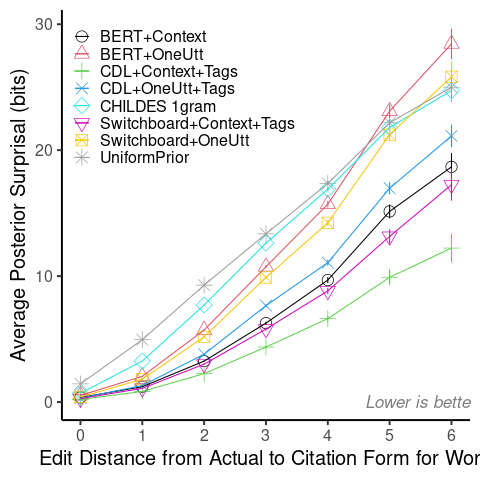

time: 315 ms (started: 2022-06-15 07:18:40 -07:00)


In [109]:
%%R

surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type != 'WFST' & edit_distance <= 6)


surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width=0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6)
) + scale_shape_manual(values=1:nlevels(as.factor(surprisal_by_edit_distance_for_plot$model))) + scale_color_manual(
        values=1:nlevels(as.factor(surprisal_by_edit_distance_for_plot$model)))

print(p1)

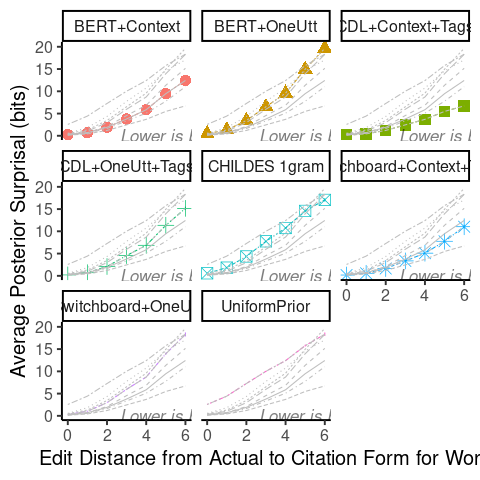

time: 622 ms (started: 2022-06-15 07:18:40 -07:00)


In [110]:
%%R
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)


surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model, linetype=likelihood_type)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=surprisal_for_gray, aes(x=edit_distance,y=mean_posterior_surprisal, linetype = line_model),colour='gray', alpha=1)+
theme(legend.position='none')
print(p1)

#### Levenshtein Distance Plots

In [111]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior" & likelihood_type == 'Levenshtein Distance')[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance_lev = merge(subset(surprisal_by_edit_distance, likelihood_type == 'Levenshtein Distance'), unigram_prior)
surprisal_by_edit_distance_lev$multiplier = 2^( surprisal_by_edit_distance_lev$unigram_prior_prob -
    surprisal_by_edit_distance_lev$mean_posterior_surprisal)

head(surprisal_by_edit_distance_lev, n=10)


   edit_distance                    model      likelihood_type
1              0             BERT+Context Levenshtein Distance
2              0              BERT+OneUtt Levenshtein Distance
3              0         CDL+Context+Tags Levenshtein Distance
4              0          CDL+OneUtt+Tags Levenshtein Distance
5              0            CHILDES 1gram Levenshtein Distance
6              0 Switchboard+Context+Tags Levenshtein Distance
7              0       Switchboard+OneUtt Levenshtein Distance
8              0             UniformPrior Levenshtein Distance
9              1             BERT+Context Levenshtein Distance
10             1              BERT+OneUtt Levenshtein Distance
   mean_posterior_surprisal mean_posterior_surprisal_sem      high       low
1                 0.3658364                  0.008981457 0.3748178 0.3568549
2                 0.5303559                  0.010011257 0.5403672 0.5203447
3                 0.2127561                  0.005911217 0.2186673 0.2068449

R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



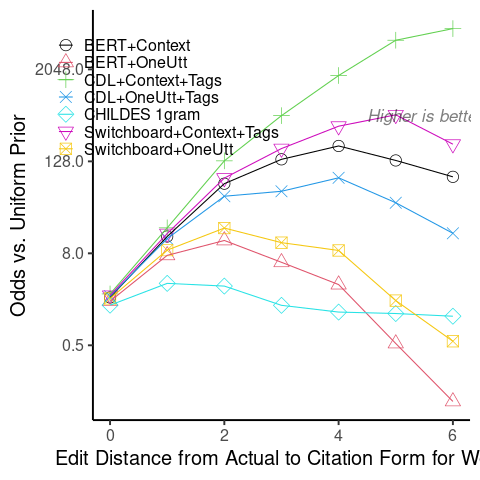

time: 293 ms (started: 2022-06-15 07:18:41 -07:00)


In [112]:
%%R

# Added: no subsetting for the odds uniform prior

p2= ggplot(subset(surprisal_by_edit_distance_lev, edit_distance <= 6 & model %in% overview_set 
& likelihood_type =='Levenshtein Distance' & model != 'UniformPrior')) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=512, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2'
) + scale_shape_manual(values = 1:8) + scale_color_manual(values = 1:8)    
print(p2)

#### WFST Plots

In [113]:
%%R
# make sure it uses the same colors
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)
surprisal_by_edit_distance_for_plot$model_shortname= gsub('\\+Tags','',surprisal_by_edit_distance_for_plot$model)
surprisal_by_edit_distance_for_plot$model_shortname = factor(surprisal_by_edit_distance_for_plot$model_shortname, levels = models_for_8_plots)

time: 8.66 ms (started: 2022-06-15 07:18:41 -07:00)


In [114]:
%%R
models_for_8_plots

[1] "CDL+Context"         "Switchboard+Context" "BERT+Context"       
[4] "CDL+OneUtt"          "Switchboard+OneUtt"  "BERT+OneUtt"        
[7] "CHILDES 1gram"       "UniformPrior"       
time: 21.3 ms (started: 2022-06-15 07:18:41 -07:00)


In [115]:
%%R
as.character(unique(surprisal_by_edit_distance$model_shortname))

numeric(0)
time: 7.95 ms (started: 2022-06-15 07:18:41 -07:00)


R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.



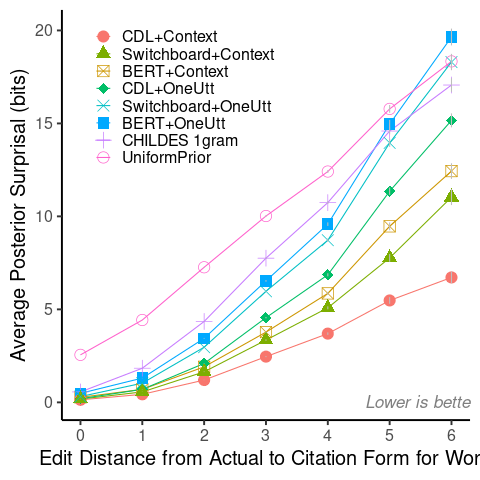

time: 482 ms (started: 2022-06-15 07:18:41 -07:00)


In [116]:
%%R



p1= ggplot(surprisal_by_edit_distance_for_plot)  + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model_shortname, 
shape=model_shortname)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6)
) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model_shortname, shape=model_shortname), size=5) + scale_shape_manual(values=1:nlevels(surprisal_by_edit_distance_for_plot$model)) + scale_color_manual(
        values=1:nlevels(surprisal_by_edit_distance_for_plot$model_shortname)) + scale_color_manual(
        values=colors_for_8_plots) + scale_shape_manual(values = shapes_for_8_plots) + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high), color="gray", width=0)


ggsave('../../output/figures/surpsisal_by_edit_distance_wfst.pdf', height=6, width=8)    
print(p1)

### Proportion Agreeing with Annotator

In [117]:
%%R
proportion_retrieved = aggregate(prior_rank ~ model + likelihood_type, successes_across_time, function(x){mean(x < 5)})
proportion_retrieved

                      model      likelihood_type prior_rank
1              BERT+Context Levenshtein Distance  0.6522569
2               BERT+OneUtt Levenshtein Distance  0.4350196
3               CDL+Context Levenshtein Distance  0.7566616
4          CDL+Context+Tags Levenshtein Distance  0.7633857
5         CDL+Older+Context Levenshtein Distance  0.7553895
6    CDL+Older+Context+Tags Levenshtein Distance  0.7609323
7          CDL+Older+OneUtt Levenshtein Distance  0.5967834
8     CDL+Older+OneUtt+Tags Levenshtein Distance  0.6030304
9                CDL+OneUtt Levenshtein Distance  0.5996456
10          CDL+OneUtt+Tags Levenshtein Distance  0.6022126
11      CDL+Younger+Context Levenshtein Distance  0.7503237
12 CDL+Younger+Context+Tags Levenshtein Distance  0.7481202
13       CDL+Younger+OneUtt Levenshtein Distance  0.5848572
14  CDL+Younger+OneUtt+Tags Levenshtein Distance  0.5765430
15            CHILDES 1gram Levenshtein Distance  0.1584244
16 Switchboard+Context+Tags Levenshtein 

## %%R
proportion_retrieved = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){mean(x == 0)})
proportion_retrieved

### Proportion Agreeing with Annotator Per Age

In [118]:
%%R
names(successes_across_time)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
time: 21.9 ms (started: 2022-06-15 07:18:43 -07:00)


In [119]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model + age + likelihood_type, successes_across_time, function(x){mean(x == 0)})

time: 2.1 s (started: 2022-06-15 07:18:43 -07:00)


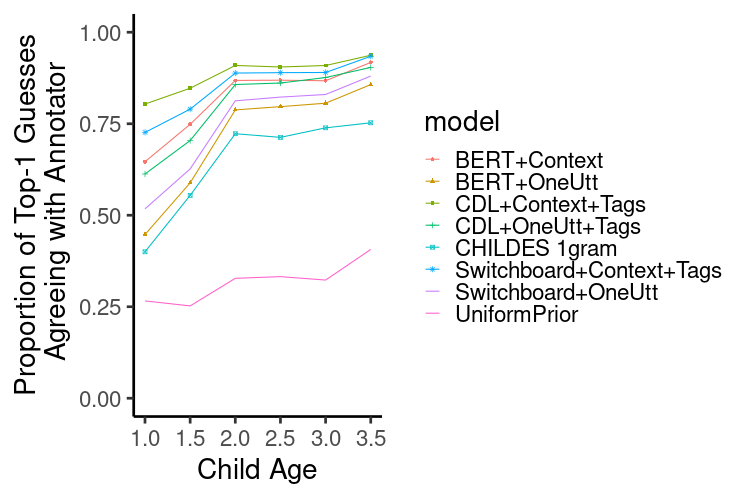

time: 245 ms (started: 2022-06-15 07:18:45 -07:00)


In [120]:
%%R -w 750 -h 500
ggplot(filter_model_subset(subset(proportion_retrieved, likelihood_type == 'WFST'), overview_set)) + geom_line(aes(x=age, y=posterior_rank, color=model)
) + geom_point(aes(x=age, y=posterior_rank, color=model, shape=model)) + coord_cartesian(ylim=c(0,1)) + xlab('Child Age') + ylab(
    'Proportion of Top-1 Guesses\n Agreeing with Annotator') + theme_classic(base_size=28) + theme(legend.background = element_blank())




### Posterior by Edit Distance by Likelihood 

In [121]:
from src.utils import load_splits
all_tokens_phono = load_splits.load_phono()

time: 7.03 s (started: 2022-06-15 07:18:45 -07:00)


In [122]:
all_tokens_phono.columns

Index(['token', 'utterance_id', 'gloss', 'transcript_id', 'utterance_order',
       'target_child_name', 'speaker_code', 'type', 'punct',
       'speaker_code_simple', 'gloss_with_punct', 'token_id', 'seq_utt_id',
       'actual_phonology', 'model_phonology', 'target_child_age',
       'bert_token_id', 'model_phonology_clean', 'actual_phonology_clean',
       'model_phonology_no_dia', 'actual_phonology_no_dia', 'cv_raw_actual',
       'cv_collapsed_actual', 'num_vowels_actual', 'cv_raw_model',
       'cv_collapsed_model', 'num_vowels_model', 'num_vowels', 'in_vocab',
       'success_token', 'yyy_token', 'partition', 'phase', 'year',
       'phase_child_sample', 'phase_child_finetune',
       'phase_child_sample_n=2_type=success_name=Alex',
       'phase_child_sample_n=2_type=success_name=Ethan',
       'phase_child_sample_n=2_type=success_name=Lily',
       'phase_child_sample_n=2_type=success_name=Naima',
       'phase_child_sample_n=2_type=success_name=Violet',
       'phase_child_sa

time: 3.2 ms (started: 2022-06-15 07:18:52 -07:00)


In [123]:
all_tokens_phono['citation_len'] = [len(x) for x in all_tokens_phono.model_phonology_no_dia]
all_tokens_phono['child_len'] = [len(x) for x in all_tokens_phono.actual_phonology_no_dia]
all_tokens_phono['phono_change'] = all_tokens_phono['child_len'] - all_tokens_phono['citation_len']
ipa_tokens = all_tokens_phono.dropna(subset=['actual_phonology_no_dia'])[['bert_token_id','phono_change']]
%R -i ipa_tokens

time: 38.8 s (started: 2022-06-15 07:18:52 -07:00)


In [124]:
%%R
ed_with_phono_change = merge(ed, ipa_tokens)

time: 2min 2s (started: 2022-06-15 07:19:31 -07:00)


In [125]:
%%R
names(ed_with_phono_change)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "likelihood_type"      
[13] "prior_rank"            "posterior_rank"        "wfst_distance"        
[16] "edit_distance"         "phono_change"         
time: 30.1 ms (started: 2022-06-15 07:21:33 -07:00)


In [126]:
%%R

#need the length of the adult string vs. the child string 

prob_by_edit_distance_likelihood = aggregate(posterior_probability ~ likelihood_type + phono_change + model, ed_with_phono_change, mean)

prob_by_edit_distance_likelihood_sem = aggregate(posterior_probability ~ likelihood_type + phono_change + model, ed_with_phono_change, sem)
names(prob_by_edit_distance_likelihood_sem) = c('likelihood_type', 'phono_change', 'model', 'sem')

prob_by_edit_distance_likelihood = merge(prob_by_edit_distance_likelihood, prob_by_edit_distance_likelihood_sem)
prob_by_edit_distance_likelihood$high = prob_by_edit_distance_likelihood$posterior_probability + prob_by_edit_distance_likelihood$sem
prob_by_edit_distance_likelihood$low = prob_by_edit_distance_likelihood$posterior_probability - prob_by_edit_distance_likelihood$sem


time: 4.44 s (started: 2022-06-15 07:21:33 -07:00)


In [127]:
%%R
prob_by_edit_distance_likelihood$likelihood_type[prob_by_edit_distance_likelihood$likelihood_type ==
    'Levenshtein Distance'] = 'Edit Distance'

time: 4.04 ms (started: 2022-06-15 07:21:38 -07:00)


In [128]:
%%R
prob_by_edit_distance_likelihood$likelihood_type = factor(prob_by_edit_distance_likelihood$likelihood_type, 
levels = c('WFST', 'Edit Distance'))

time: 19 ms (started: 2022-06-15 07:21:38 -07:00)


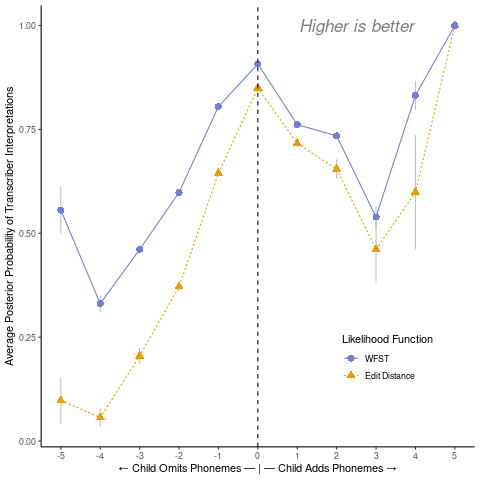

time: 521 ms (started: 2022-06-15 07:21:38 -07:00)


In [129]:
%%R
p1 = ggplot(subset(prob_by_edit_distance_likelihood, model == "CDL+Context+Tags")) + geom_errorbar(
aes(x=phono_change, ymin = low, ymax=high), color='gray', width=0) + geom_line(aes(x=phono_change, y=posterior_probability,
    color = likelihood_type, linetype = likelihood_type )) + geom_point(aes(x=phono_change, y=posterior_probability,
    color = likelihood_type, shape=likelihood_type), size=3) + theme_classic() + ylab('Average Posterior Probability of Transcriber Interpretations') + xlab (
    '← Child Omits Phonemes — | — Child Adds Phonemes →') + geom_vline(xintercept=0, linetype='dashed'
) + scale_x_continuous(breaks=c(-5:5), labels = c(-5:5))  + scale_shape_discrete(name = "Likelihood Function") + scale_linetype_discrete(name = "Likelihood Function") + theme(legend.position = c(.8, .2)
) + annotate("text", label="Higher is better", 
    x=2.5, y=1, alpha=.5, size=6, fontface ="italic")  + scale_color_manual(values=c("#6f80d6", "#E69F00"), name = "Likelihood Function")

ggsave("../../output/figures/likelihood_function_by_change.png", width = 5, height=5)
print(p1)

# Child-Specific Analyses

In [130]:
all_tokens_phono_short = all_tokens_phono[['bert_token_id','target_child_name']]
%R -i all_tokens_phono_short

time: 1min (started: 2022-06-15 07:21:38 -07:00)


In [131]:
%%R
successes_across_time_with_child_label = merge(successes_across_time, all_tokens_phono_short)

time: 1min 13s (started: 2022-06-15 07:22:38 -07:00)


In [132]:
%%R
names(successes_across_time_with_child_label)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "target_child_name"    
time: 30.1 ms (started: 2022-06-15 07:23:52 -07:00)


In [133]:
%%R
posterior_entropy_by_child = aggregate(posterior_entropy ~ model + likelihood_type + target_child_name, successes_across_time_with_child_label, mean)
subset(posterior_entropy_by_child, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')

               model likelihood_type target_child_name posterior_entropy
22  CDL+Context+Tags            WFST              Alex         0.4437506
58  CDL+Context+Tags            WFST             Ethan         0.5692354
94  CDL+Context+Tags            WFST              Lily         0.2667697
130 CDL+Context+Tags            WFST             Naima         0.3547579
166 CDL+Context+Tags            WFST            Violet         0.3809232
202 CDL+Context+Tags            WFST           William         0.4558486
time: 971 ms (started: 2022-06-15 07:23:52 -07:00)


In [134]:
%%R
proportion_retrieved = aggregate(prior_probability ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(-1 *log(x, base=2))})
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')

               model likelihood_type target_child_name prior_probability
22  CDL+Context+Tags            WFST              Alex          3.951032
58  CDL+Context+Tags            WFST             Ethan          3.346231
94  CDL+Context+Tags            WFST              Lily          2.995283
130 CDL+Context+Tags            WFST             Naima          3.171910
166 CDL+Context+Tags            WFST            Violet          3.190543
202 CDL+Context+Tags            WFST           William          3.399829
time: 1.27 s (started: 2022-06-15 07:23:53 -07:00)


In [135]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(proportion_retrieved)[4] = 'proportion_top_1'
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')


               model likelihood_type target_child_name proportion_top_1
22  CDL+Context+Tags            WFST              Alex        0.8751579
58  CDL+Context+Tags            WFST             Ethan        0.8288934
94  CDL+Context+Tags            WFST              Lily        0.9316112
130 CDL+Context+Tags            WFST             Naima        0.9056785
166 CDL+Context+Tags            WFST            Violet        0.8956460
202 CDL+Context+Tags            WFST           William        0.8695885
time: 939 ms (started: 2022-06-15 07:23:54 -07:00)


In [136]:
%%R
proportion_retrieved = aggregate(prior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(proportion_retrieved)[4] = 'proportion_top_1'
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')



               model likelihood_type target_child_name proportion_top_1
22  CDL+Context+Tags            WFST              Alex        0.4768764
58  CDL+Context+Tags            WFST             Ethan        0.5781250
94  CDL+Context+Tags            WFST              Lily        0.5713066
130 CDL+Context+Tags            WFST             Naima        0.5840953
166 CDL+Context+Tags            WFST            Violet        0.5601041
202 CDL+Context+Tags            WFST           William        0.5530020
time: 1.02 s (started: 2022-06-15 07:23:55 -07:00)
